In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Pricing Model For DAO Token Launch

Discretize time into increments and keep track of the starting price and ending price for each increment. If ending price is greater than y% of the starting price for a given time increment, calculate how many tokens must be sold into the pool to bring the ending price exactly to y% of the starting price. 


Definitions: 
    Time increment: Can be uniform or random of any length. 
    
    Cap: Function that determines the maximum price at the end of a time increment.
    
    k: constant product
    
    t: tokens (kinn dao tokens)


Assumptions:
    Constant product, DAO is the only one adding to liquidity
    
    No slippage
    
    t and algo are the only liquidity pair being considered
    
    Initial liquidity will be 6% (6e8) of token supply (1e10), valued at 4e5
    
    Price growth: True price growth for each increment is limited to x% of starting price. Conditions below are expected 
                  values for how many algos will flow into the pool estimated as a multiple of starting price in a given 
                  time increment. For instance, if the growth assumption for a time increment was 10, then the amount of 
                  algos assumed to flow into the pool would be the amount needed to see 10x price growth at the current k 
                  value. In practice, we probably won't let the price rise 10x and then take it down to 1.25x because that 
                  price action would look bad. Instead, we would probably sell tokens frequently keeping price at 1.25x the 
                  start price. Because we use the same starting price for all conditions, we only assume that net volume of 
                  algo flowing in will be different and relative differences in volume are what really matter.
                  
    Min Tokens/t: The minimum amount of tokens to distribute per time increment to hit 20% by the end of simulation. 20% is 
                  the amount allocated for public sale. If algo volume in isn't great enough to allow DAO to sell the min 
                  tokens in that time increment, then the remainder is added to liquidity at the current price. That is why 
                  an observed price growth of y% per unit time is the worst possible case, max price growth without getting 
                  to sell tokens. 
    
    
Conditions:

    High price growth: np.linspace(10,1,7) 
    
    Medium price growth: np.linspace(16,1,7) 
    
    Low price growth: np.linspace(3,1,7) 
    
    Worst case: np.ones(7)*1.25 
    
    
Equations (numbers for reference):

    (0) k = algo*t
    
    (1) p = algo/t
    
        algo=t*p
    
        k = p*(t**2)
    
    (2) t = np.sqrt(k/p)
    
        t = algo/p  
    
        k = (algo**2)/p
    
    (3) algo = np.sqrt(p*k)
    
    
Find: For each time increment and growth condition, how many tokens do we sell, and what is the net algo balance?

In [2]:
# create price cap that calculates the max price for a given time increment
def cap(startp, nextp, percent, max_growth=1.25):
    """
    startp: starting price for time increment
    nextp: ending price for time increment
    percent: percent of difference
    """
    if nextp/startp <= max_growth:  # no cap
        return nextp

    return startp*max_growth + (nextp-(startp*max_growth))*percent  # capped

In [23]:
cap(100,200,0.25), cap(100,125,0.25), cap(100,200,0), cap(100,125,0), cap(100,200,0, 1.33)

(143.75, 125, 125.0, 125, 133.0)

In [14]:
# Final model, going with 0 percent of difference for cap because it's a bit more conservative on price action, so it  
# distributes more tokens more quickly
overbid_results = {}
d = 7  # number of time increments
# price growth assumptions: 
overbids = [np.linspace(10,1,d), np.linspace(6,1,d), np.linspace(3,1,d), np.ones(d)*1.25, np.ones(d)]  # 1.25 is worst case 
for overbid in overbids:
    tsums = []  # sum of tokens added, to check if 20% has been disitrbuted at the end
    all_ts = []  # all token amounts for time increments
    init_t_liquidity = []  # always 0.06*1e10
    init_algo_liquidity = []  # always 4e5
    all_ps = []  # all prices
    all_algos_raised = []  # net algos, amount made - spent on liqduity
    all_algos_spent_lqdt = []  # algos spent on liquidity
    all_algos_made_only = []  # algos made from token sales
    percents = [0]  # lower percent means higher chance of distributing all tokens, testing 0% only here but could add more
    for percent in percents:
        # reinitialize for every percent tested, only one in this case
        t = 0.06*1e10  # fixed at 6% initial tokens for launch
        p = 1/1500  # starting price
        algo = t*p  # starting algo
        k = t*algo  # starting k
        
        ts = []
        ps = []
        algos_raised = []
        algos_spent_lqdt = []
        algos_made_only = []
        for day in range(d):
            ps.append(p)  # append starting price
            p = cap(p,overbid[day]*p,percent)  # capped price given growth assumption
            # ps[-1]: start price, p: end price, overbid[day]*ps[-1]: theoretical price given assumed algo volume inflow
            token_dist_min_keep_up = (0.2-(np.sum(ts)+t)/1e10)/(d-day)  # decide min tokens b4 sales, frontloads release 
            # calc how many algos above cap would have to flow in to achieve some multiple of starting price
            algos_from_sale = np.sqrt((overbid[day]*ps[-1])*k)-np.sqrt(p*k) # from Eqn (3)
            if (np.sum(ts)+t+(algos_from_sale/p))<0.2*1e10:  # record all algos and tokens
                t_added = algos_from_sale/p  # assuming price is perfectly fixed at cap, how many tokens are bought?
            else:  # (algos_from_sale/p) will put you over, so won't be able to sell as many tokens
                t_added = token_dist_min_keep_up  # add the minimum amount of tokens
                algos_from_sale = token_dist_min_keep_up*p
                
            algos_made_only.append(algos_from_sale)  
            algos_raised.append(algos_from_sale)  # value may change if more tokens are needed to add to liquidity
            ts.append(t_added)    
            tpct_added = t_added/1e10  # true token percentage added assuming algo volume above and perfect execution
            if tpct_added < token_dist_min_keep_up:  # if less than remaining tokens/n_days left, add to liquidity
                ts[-1] = token_dist_min_keep_up*1e10  # update ts to be the minimum required tokens added
                keep_up_tokens = (token_dist_min_keep_up-tpct_added)*1e10
                # I know price, and previous k value, need to use price and k to get t or algo
                new_t = np.sqrt(k/p) + keep_up_tokens  # current tokens + added liquidity
                new_algo = np.sqrt(k*p) + keep_up_tokens*p  # current algos + added liquidity
                algos_raised[-1] -= keep_up_tokens*p  # losing algos to liquidity
                k = new_t*new_algo  # update k at the very end 
                   
        tsums.append((np.sum(ts)+t)/1e10)  # sum of t added at each time increment + initial liquidity
        print('Cap:', np.round(percent,3), ', % total tokens sold:', tsums[-1], ', algos raised:', np.sum(algos_raised))
        all_algos_raised.append(algos_raised)
        all_algos_made_only.append(algos_made_only)
        all_ts.append(ts)
        all_ps.append(ps)
        init_t_liquidity.append(t)
        init_algo_liquidity.append(algo)
    overbid_results[overbid[0]] = {'tsums':tsums, 'all_algos_raised':all_algos_raised, 'all_ts':all_ts,
                                   'all_ps':all_ps, 'init_t_liquidity':init_t_liquidity, 
                                   'init_algo_liquidity':init_algo_liquidity, 'algos_made':all_algos_made_only} 

Cap: 0 , % total tokens sold: 0.2 , algos raised: 43535.65714813804
Cap: 0 , % total tokens sold: 0.2 , algos raised: 983288.6431094467
Cap: 0 , % total tokens sold: 0.2 , algos raised: -200283.16989008116
Cap: 0 , % total tokens sold: 0.2 , algos raised: -2512247.721354167
Cap: 0 , % total tokens sold: 0.2 , algos raised: -933333.3333333336


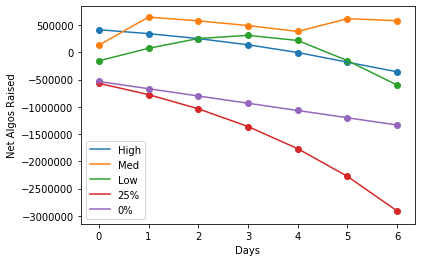

In [15]:
lbls = ['High', 'Med', 'Low', '25%', '0%']
for n,lbl in zip(overbid_results.keys(), lbls):
    plt.plot(np.cumsum(overbid_results[n]['all_algos_raised'][0])-400000, label=lbl)
    plt.scatter(range(7), np.cumsum(overbid_results[n]['all_algos_raised'][0])-400000)
plt.legend()
plt.ylabel('Net Algos Raised')
plt.xlabel('Days')
plt.show()

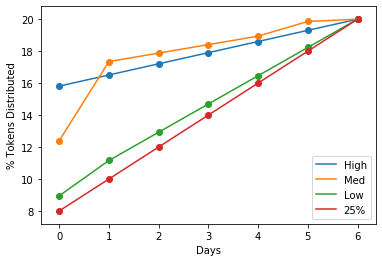

In [17]:
for n,lbl in zip([10,6,3,1.25], lbls):
    plt.plot(6+(np.cumsum(overbid_results[n]['all_ts'][0])/1e8), label=lbl)
    plt.scatter(range(7),6+(np.cumsum(overbid_results[n]['all_ts'][0])/1e8))
plt.legend()
plt.xlabel('Days')
plt.ylabel('% Tokens Distributed')
plt.show()

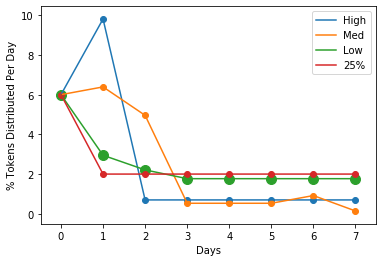

In [18]:
for n,lbl in zip([10,6,3,1.25], lbls):
    plt.plot(np.concatenate([[6],np.array(overbid_results[n]['all_ts'][0])/1e8]), label=lbl)
    if n==3:
        plt.scatter(range(8),np.concatenate([[6],np.array(overbid_results[n]['all_ts'][0])/1e8]),s=100)
    else:
        plt.scatter(range(8),np.concatenate([[6],np.array(overbid_results[n]['all_ts'][0])/1e8]))
plt.legend()
plt.xlabel('Days')
plt.ylabel('% Tokens Distributed Per Day')
plt.show()

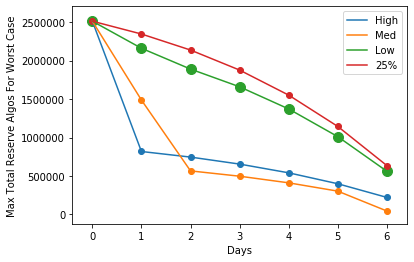

In [19]:
# how much algo would we need in reserve if a given growth curve performed at worst case for the rest of the week?
for n,lbl in zip([10,6,3,1.25], lbls):
    tarr = (0.2-(np.cumsum(np.concatenate([[0.06*1e10],overbid_results[n]['all_ts'][0]]))[:-1])/1e10)/(7-np.arange(7))
    tarr = (tarr.reshape(-1,1)*np.ones((7,7)))
    for i in range(7):
        tarr[i,:i-7] = 0 
    parr = np.array(overbid_results[n]['all_ps'][0]+[1.25*overbid_results[n]['all_ps'][0][-1]])[1:]
    worst_costs = np.sum((tarr*parr*1e10),1)
    plt.plot(worst_costs, label=lbl)
    if n==3:
        plt.scatter(range(7),worst_costs,s=100)
    else:
        plt.scatter(range(7),worst_costs)
plt.legend()
plt.xlabel('Days')
plt.ylabel('Max Total Reserve Algos For Worst Case')
plt.show()

In [47]:
def sim(max_growth=1.25, show=True):
    # Final model, going with 0 percent of difference for cap because it's a bit more conservative on price action, so it  
    # distributes more tokens more quickly
    overbid_results = {}
    d = 7  # number of time increments
    # price growth assumptions: 
    overbids = [np.linspace(10,1,d), np.linspace(6,1,d), np.linspace(3,1,d), 
                np.ones(d), np.ones(d)*max_growth]  # max_growth (last one) is worst case
    for overbid in overbids:
        tsums = []  # sum of tokens added, to check if 20% has been disitrbuted at the end
        all_ts = []  # all token amounts for time increments
        init_t_liquidity = []  # always 0.06*1e10
        init_algo_liquidity = []  # always 4e5
        all_ps = []  # all prices
        all_algos_raised = []  # net algos, amount made - spent on liqduity
        all_algos_spent_lqdt = []  # algos spent on liquidity
        all_algos_made_only = []  # algos made from token sales
        percents = [0]  # lower percent means higher chance of distributing all tokens, testing 0% only here but could add more
        for percent in percents:
            # reinitialize for every percent tested, only one in this case
            t = 0.06*1e10  # fixed at 6% initial tokens for launch
            p = 1/1500  # starting price
            algo = t*p  # starting algo
            k = t*algo  # starting k

            ts = []
            ps = []
            algos_raised = []
            algos_spent_lqdt = []
            algos_made_only = []
            for day in range(d):
                ps.append(p)  # append starting price
                p = cap(p, overbid[day]*p, percent, max_growth)  # capped price given growth assumption
                # ps[-1]: start price, p: end price, overbid[day]*ps[-1]: theoretical price given assumed algo volume inflow
                token_dist_min_keep_up = (0.2-(np.sum(ts)+t)/1e10)/(d-day)  # decide min tokens b4 sales, frontloads release 
                # calc how many algos above cap would have to flow in to achieve some multiple of starting price
                algos_from_sale = np.sqrt((overbid[day]*ps[-1])*k)-np.sqrt(p*k) # from Eqn (3)
                if (np.sum(ts)+t+(algos_from_sale/p))<0.2*1e10:  # record all algos and tokens
                    t_added = algos_from_sale/p  # assuming price is perfectly fixed at cap, how many tokens are bought?
                else:  # (algos_from_sale/p) will put you over, so won't be able to sell as many tokens
                    t_added = token_dist_min_keep_up  # add the minimum amount of tokens
                    algos_from_sale = token_dist_min_keep_up*p

                algos_made_only.append(algos_from_sale)  
                algos_raised.append(algos_from_sale)  # value may change if more tokens are needed to add to liquidity
                ts.append(t_added)    
                tpct_added = t_added/1e10  # true token percentage added assuming algo volume above and perfect execution
                if tpct_added < token_dist_min_keep_up:  # if less than remaining tokens/n_days left, add to liquidity
                    ts[-1] = token_dist_min_keep_up*1e10  # update ts to be the minimum required tokens added
                    keep_up_tokens = (token_dist_min_keep_up-tpct_added)*1e10
                    # I know price, and previous k value, need to use price and k to get t or algo
                    new_t = np.sqrt(k/p) + keep_up_tokens  # current tokens + added liquidity
                    new_algo = np.sqrt(k*p) + keep_up_tokens*p  # current algos + added liquidity
                    algos_raised[-1] -= keep_up_tokens*p  # losing algos to liquidity
                    k = new_t*new_algo  # update k at the very end 

            tsums.append((np.sum(ts)+t)/1e10)  # sum of t added at each time increment + initial liquidity
            if show:
                print('Cap:', np.round(percent,3), ', % total tokens sold:', tsums[-1], ', algos raised:', np.sum(algos_raised))
            all_algos_raised.append(algos_raised)
            all_algos_made_only.append(algos_made_only)
            all_ts.append(ts)
            all_ps.append(ps)
            init_t_liquidity.append(t)
            init_algo_liquidity.append(algo)
        overbid_results[overbid[0]] = {'tsums':tsums, 'all_algos_raised':all_algos_raised, 'all_ts':all_ts,
                                       'all_ps':all_ps, 'init_t_liquidity':init_t_liquidity, 
                                       'init_algo_liquidity':init_algo_liquidity, 'algos_made':all_algos_made_only} 
    return overbid_results

def extreme_case(max_growth=1.25):
    # inits
    t = 0.06*1e10  # fixed at 6% initial tokens for launch
    startp = 1/1500  # starting price
    algo = t*startp  # starting algo
    k = t*algo  # starting k

    p = startp
    algos_raised = []
    t_sell = 0.14*1e10
    for i in range(7):
        p *= max_growth  # sell exactly 2% of tokens every day at max price, simple case
        algos_in = 0.02*1e10*p  # assumes we perfectly time sells with buys... lower bound 
        algos_raised.append(algos_in)
    return algos_raised

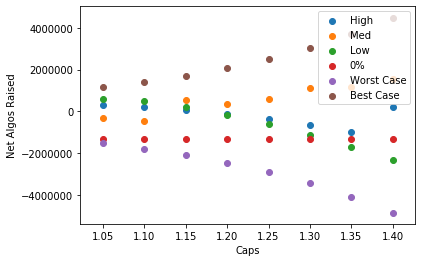

In [48]:
# I want to see best case, worst case, and the test assumptions in between
lbls = ['High', 'Med', 'Low', '0%', 'Worst Case', 'Best Case']
caps = np.arange(1.05,1.41,0.05)
ags = []
for c in caps:
    overbid_results = sim(c, show=False)
    ag = [np.sum(overbid_results[n]['all_algos_raised'][0])-400000 for n in overbid_results.keys()]
    # calculate best case
    ag.append(np.sum(best_case(c)))
    ags.append(ag)
ags = np.array(ags)
for i, lbl in enumerate(lbls):
    plt.scatter(caps, ags[:, i], label=lbl)
plt.legend()
plt.ylabel('Net Algos Raised')
plt.xlabel('Caps')
plt.show()


# What's the max price growth we could tolerate on day 1 before we'd run out of tokens?

In [2]:
# inits
t = 0.06*1e10  # fixed at 6% initial tokens for launch
startp = 1/1500  # starting price
algo = t*startp  # starting algo
k = t*algo  # starting k

# if public buys tokens at 1.25*startp, need to sell 20%-6%=14% of token supply 
# how much algo would it cost to sell 14% of tokens at 0=startp*1.25?
p = 1.25*startp
t_sell = 0.14*1e10
algos_in = t_sell*p  # assumes we perfectly time sells with buys... lower bound 
# what would be the hypothetical price if algos_in worth of tokens are bought
algocap = np.sqrt(p*k)  # algo at cap price
algomax = algocap+algos_in
tmax = k/algomax  # new tokens
(algomax/tmax)/startp  # 16.279, max price increase on day 1 to run out of tokens

16.27880937881883

In [55]:
algos_in, p

(1166666.6666666667, 0.0006666666666666666)

In [38]:
np.sqrt(k/(overbid*start_p)), overbid*start_p/p

(2710523.708715754, 39200.0)

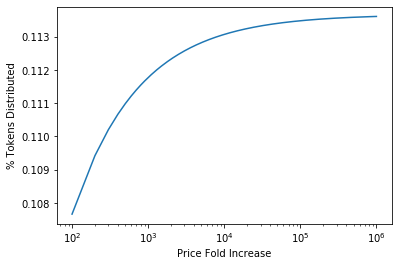

In [51]:
plt.plot(overbid_folds, ts)
plt.xscale('log')
plt.ylabel('% Tokens Distributed')
plt.xlabel('Price Fold Increase')
plt.show()

max price increase in a day is 100x

In [42]:
algos_from_sale

399352736.3794844

In [36]:
overbid, algos_from_sale, (t_added+t)/1e10

(49000, 88096560.88921465, 0.1133945790891234)

In [32]:
np.sqrt(k/p)/1e10, np.sqrt(k/(overbid*start_p))/1e10

(0.05366563145999496, 0.0018983159915049981)

In [2]:
########### best case?
# inits
t = 0.06*1e10  # fixed at 6% initial tokens for launch
startp = 1/1500  # starting price
algo = t*startp  # starting algo
k = t*algo  # starting k

p = startp
algos_raised = []
t_sell = 0.14*1e10
for i in range(7):
    p *= 1.25  # sell exactly 2% of tokens every day at max price, simple case
    algos_in = 0.02*1e10*p  # assumes we perfectly time sells with buys... lower bound 
    algos_raised.append(algos_in)

In [3]:
np.sum(algos_raised)

2512247.721354166

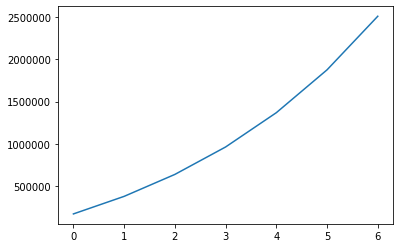

In [5]:
plt.plot(np.cumsum(algos_raised))

In [ ]:
########### best case?
# inits
t = 0.06*1e10  # fixed at 6% initial tokens for launch
startp = 1/1500  # starting price
algo = t*startp  # starting algo
k = t*algo  # starting k

p = startp
algos_raised = []
t_sell = 0.14*1e10
for i in range(7):
    p *= 1.25  # sell exactly 2% of tokens every day at max price, simple case
    if i==0:
        algos_in = 0.01*1e10*p  # assumes we perfectly time sells with buys... lower bound 
        
    algos_raised.append(algos_in)